In [45]:
# EAE 130b - Aircraft Performance and Design
# Assignment 2 - Improved Drag Polar
# Group 9
# 22 April 2025


import numpy as np 
import matplotlib.pyplot as plt

# Reference Area for Each Component

W_0 = 7912 # source - A2 report float(input("Enter the takeoff gross weight (lbs): "))
S_ref_wing = 396 # source - Gama & Justin float(input("Enter the reference wing area (ft^2): "))
S_ref_fuselage = 572 # 130B - A1
S_ref_ht = 77 # 130B - A1
S_ref_vt = 109 # 130B - A1
S_ref_engine = 200 # CHECK
S_ref_landing_gear = 100 # CHECK
c = 1.0447 # Source - Gama
d = 0.5326 # Source - Gama
S_wet = (10 ** c) * (W_0 ** d)# 4605 * 142.45 # float(input("Enter the reference wing wet area (ft^2): "))
V = 250 * 0.5
mu = 3.737 * (10**-7) # slug/ft-s - dynamic viscoisty of air
Ma = (V * 1.688) / 1128 # 1128 ft/s is speed of sound
#print(Ma)

# From OpenVSP
#Theo_Area   Wet_Area   Theo_Vol    Wet_Vol  Name
#  430.171    396.135    108.759    106.941  Wing
#  430.171    396.135    108.759    106.941  Wing
#   87.687     77.439     14.066     13.264  tail
#   87.677     77.429     13.850     13.060  tail
#  124.043    109.413     25.385     23.909  vertical tail
#  558.291    509.112    667.370    649.826  Fuselage
#  113.322     63.100     77.589     46.131  cockpit

# Skin-Friction Coefficient Cf for each component

FF = 1 # form factor for flat plate - no pressure gradients

l_fuselage = 40 # length of fuselage
l_wing = 7 # MAC
l_ht = 4.5
l_vt = 5
l_engine = 60/12 # Google data for Pt6
l_lg = 5 # CHECK

rho = 0.00238
rho_takeoff = 0.00238
rho_cruise = 0.0023672
rho_landing = 0.00238
rho_climb = (rho_cruise + rho_takeoff)/2

Re_wing = (rho * V * l_wing) / mu
Re_fuselage = (rho * V * l_fuselage) / mu
Re_ht = (rho * V * l_ht) / mu
Re_vt = (rho * V * l_vt) / mu
Re_engine = (rho * V * l_engine) / mu
Re_lg = (rho * V * l_lg) / mu

# Laminar flow
Cf_wing_lam = 1.328 / np.sqrt(Re_wing)
Cf_fuselage_lam = 1.328 / np.sqrt(Re_fuselage)
Cf_ht_lam = 1.328 / np.sqrt(Re_ht)
Cf_vt_lam = 1.328 / np.sqrt(Re_vt)
Cf_engine_lam = 1.328 / np.sqrt(Re_engine)
Cf_landing_gear_lam = 1.328 / np.sqrt(Re_lg)

# Turbulent flow 
Cf_wing_tur = 0.455 / (((np.log10(Re_wing))**2.58) * ((1 + (0.144 * (Ma**2)))**0.65))
Cf_fuselage_tur = 0.455 / (((np.log10(Re_fuselage))**2.58) * ((1 + (0.144 * (Ma**2)))**0.65))
Cf_ht_tur = 0.455 / (((np.log10(Re_ht))**2.58) * ((1 + (0.144 * (Ma**2)))**0.65))
Cf_vt_tur = 0.455 / (((np.log10(Re_vt))**2.58) * ((1 + (0.144 * (Ma**2)))**0.65))
Cf_engine_tur = 0.455 / (((np.log10(Re_engine))**2.58) * ((1 + (0.144 * (Ma**2)))**0.65))
Cf_landing_gear_tur = 0.455 / (((np.log10(Re_lg))**2.58) * ((1 + (0.144 * (Ma**2)))**0.65))

# Weighted average Cf - for gen aviation with classic production metal 
# - laminar flow estiamtion guidelines (Raymer CH12 - LecB03 slide 13),
#  0% Fuselage and 10% for wings and tails

chord_wing = 7
Cf_wing = (0.1*Cf_wing_lam) + (0.9*Cf_wing_tur)
Cf_fuselage = Cf_fuselage_tur
Cf_ht = (0.1*Cf_ht_lam) + (0.9*Cf_ht_tur)
Cf_vt = (0.1*Cf_vt_lam) + (0.9*Cf_vt_tur)
Cf_engine = Cf_engine_tur
Cf_landing_gear = (0.1*Cf_landing_gear_lam) + (0.9*Cf_landing_gear_tur)

#print(Cf_wing)
#print(Cf_fuselage)
#print(Cf_ht)

# Friction Drag: Form Factors
xc_max = 0.3 * chord_wing # chordwise location of max thickness - NACA 0012 airfoil
# Max thickness 12% at 30% chord
tc = 0.12 # max thickness of airfoil 0012 = 0.12
sweep_wing = np.deg2rad(2)
sweep_ht = 0
sweep_vt = np.deg2rad(20)

# wing
term1 = 1 + ((0.6 / xc_max) * tc) + (100 * (tc**4))
term2 = 1.34 * (Ma**0.18) * ((np.cos(sweep_wing))**0.28)
FF_wing = term1 * term2
#print(FF_wing)

# ht
term3 = 1 + ((0.6 / xc_max) * tc) + (100 * (tc**4))
term4 = 1.34 * (Ma**0.18) * ((np.cos(sweep_ht))**0.28)
FF_ht = term3 * term4
#print(FF_ht)

# vt 
term5 = 1 + ((0.6 / xc_max) * tc) + (100 * (tc**4))
term6 = 1.34 * (Ma**0.18) * ((np.cos(sweep_vt))**0.28)
FF_vt = term5 * term6

# fuselage
f = l_fuselage / (np.sqrt((4/np.pi) * S_ref_fuselage)) # fineness ratio - lecB02 - slide 14
#print(f) # since f = 1.48 < 6, FF is the following

FF_fuselage = (0.9 + (5/(f**1.5)) + (f/400))
#print(FF_fuselage)

# Interference factor

Q_wing = 1.2 # unfilleted low wing - LecB03 Slide 15
Q_fuselage = 1 
Q_vt = 1.03
Q_ht = 1.08
Q_tail = 1.05 # for conventional tail

# Miscellaneous Form of Drag

# Speed brakes, spoilers, bluff surfaces
u = np.deg2rad(11.4) # longitudinal ground clearance angle
A_max = (1.63*12 * 2) + (2.1 * 16 * 2) + (2 * 1 * 5) # guess for surface area of flaps
Dq_brakes = 3.83 * (u ** 2.5) * A_max

# Fuselage upsweep (subsonic)
Dq_fuselage = S_ref_fuselage * (0.139 + 0.419 * ((Ma - 0.161)**2))
#print(Dq_fuselage)

# Feathered props - when engine fails

N_blades = 5
A_blade = 1 * 2 # ft^2 - need to check value
A_blades = N_blades * A_blade
A_disk = np.pi * (2 ** 2)
sigma = A_blades / A_disk # is propeller solidity, i.e. total blade area divided by disk area
Dq_prop = 0.1 * sigma * A_disk
#print(Dq_prop)

#Landing gear drag 
Dq_lg = 0.25 + 0.15 # check

drag_area_sum = Dq_brakes + Dq_fuselage + Dq_lg + Dq_prop

CD_mis = (1/S_ref_wing) * drag_area_sum
#print(CD_mis)

# Component Build-up for parasite drag coeff

comp_wing = Cf_wing * FF_wing * Q_wing * S_ref_wing
comp_fuselage = Cf_fuselage * FF_fuselage * Q_fuselage * S_ref_fuselage
comp_ht = Cf_ht * FF_ht * Q_ht * S_ref_ht
comp_vt = Cf_vt * FF_vt * Q_vt * S_ref_vt

sum_components = comp_wing + comp_fuselage + comp_ht + comp_vt

CD_0 = (1/S_ref_wing) * (sum_components) + CD_mis


# Leakage and Protuberance Drag
CD_leak = 0.06 * CD_0 # estimated as a percent of total parasite drag 5-10% for prop

CD_0 = CD_0 + CD_leak
print(CD_0) # 0.0193 in previous 130A - A3 code

0.2579128265412999


In [46]:
chord_flap = 0.4 * chord_wing # check
S_ref_flap = 0.25 * S_ref_wing # check
del_flap = np.deg2rad(40) # angle of delfection for flap assumed to be 30 deg - check

delta_cD0_landing_flaps = 1.7 * ((chord_flap / chord_wing)**1.38) * (S_ref_flap / S_ref_wing) * ((np.sin(del_flap))**2)# for plain flap
print(delta_cD0_landing_flaps)

0.049586871800762745


0.2579128265412999
0.04501351925831384
0.2729128265412999
0.04791761727497924
0.30749969834206264
0.05122228053532264
0.2929128265412999
0.04791761727497924
0.32749969834206266
0.05122228053532264


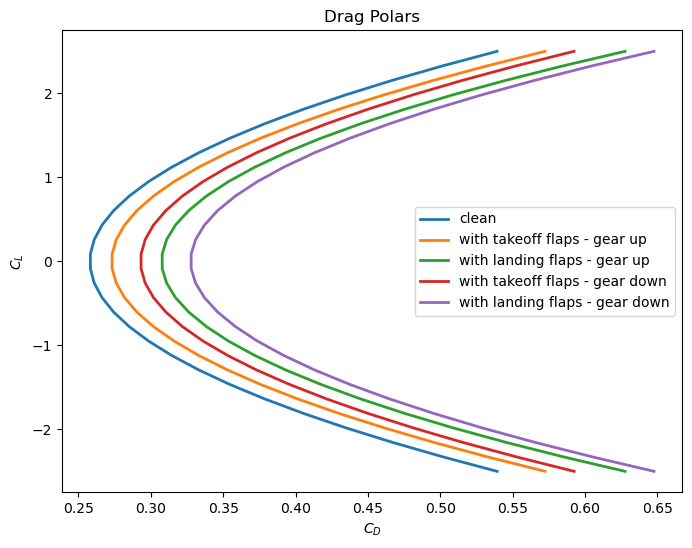

In [47]:
# DRAG POLAR
# From Metabook pg. 35
# From Figure 3.6 of Raymer's text, wetted area to reference wing area has been estimated to be 4 (Cessna Skyline RG)

#S_wet_S_ref =  S_wet / S_ref_wing # 4 - from Raymer's text
#c_f = 0.0055 # figure 4.4 on Metabook - "light aircraft - single engine"

parasite_drag_coeff =  CD_0 # c_f * S_wet_S_ref

AR = 60/7 # span / chord of wing

# AVL will give lift-induced drag

cL_clean = np.linspace(-2.5, 2.5, 30)
cL_takeoff = np.linspace(-2.5, 2.5, 30)
cL_landing = np.linspace(-2.5, 2.5, 30)
cL_takeoff2 = np.linspace(-2.5, 2.5, 30)
cL_landing2 = np.linspace(-2.5, 2.5, 30)

eff_clean = 0.825 #float(input("Enter the Oswald efficiency for clean configuration (0.80 ~ 0.85): "))
eff_takeoff = 0.775 #float(input("Enter the Oswald efficiency for takeoff flaps configuration (0.75 ~ 0.80): "))
eff_landing_flaps = 0.725 #float(input("Enter the Oswald efficiency for landing flaps configuration (0.70 ~ 0.75): "))

delta_cD0_takeoff = 0.015 #float(input("Enter the change in parasite drag coefficient (C_D0) for takeoff flaps (0.010 ~ 0.020): "))
#delta_cD0_landing_flaps = 0.065 #float(input("Enter the change in parasite drag coefficient (C_D0) for landing flaps (0.055 ~ 0.075): "))
delta_cD0_landing_gear = 0.02 #float(input("Enter the change in parasite drag coefficient (C_D0) for landing gear (0.015 ~ 0.025): "))

# Clean drag polar
cD_clean = parasite_drag_coeff + (1 / (np.pi * eff_clean * AR)) * (cL_clean ** 2)
print(parasite_drag_coeff)
print(1 / (np.pi * eff_clean * AR))
# Takeoff flaps - gear up drag polar
cD_takeoff_1 = (parasite_drag_coeff + delta_cD0_takeoff) + (1 / (np.pi * eff_takeoff * AR)) * (cL_takeoff ** 2)
print(parasite_drag_coeff + delta_cD0_takeoff)
print(1 / (np.pi * eff_takeoff * AR))

# Landing flaps - gear up drag polar
cD_landing_flaps_1 = (parasite_drag_coeff + delta_cD0_landing_flaps) + (1 / (np.pi * eff_landing_flaps * AR)) * (cL_landing ** 2)
print(parasite_drag_coeff + delta_cD0_landing_flaps)
print(1 / (np.pi * eff_landing_flaps * AR))

# Takeoff flaps - gear down drag polar - this is here in case we decide to do a retractable one
cD_takeoff_2 = (parasite_drag_coeff + delta_cD0_takeoff + delta_cD0_landing_gear) + (1 / (np.pi * eff_takeoff * AR)) * (cL_takeoff ** 2)
print(parasite_drag_coeff + delta_cD0_takeoff + delta_cD0_landing_gear)
print(1 / (np.pi * eff_takeoff * AR))

# Landing flaps - gear down drag polar - this is here in case we decide to do a retractable one
cD_landing_flaps_2 = (parasite_drag_coeff + delta_cD0_landing_flaps + delta_cD0_landing_gear) + (1 / (np.pi * eff_landing_flaps * AR)) * (cL_landing ** 2)
print(parasite_drag_coeff + delta_cD0_landing_flaps + delta_cD0_landing_gear)
print(1 / (np.pi * eff_landing_flaps * AR))

# Landing gear drag polar
# cD_landing_gear = (parasite_drag_coeff + delta_cD0_landing_gear) + (1 / (np.pi * eff_clean * AR)) * (cL_landing ** 2) # Just used the clean efficiency here 
# (DELETE LATER: looks like that's what the sample code did as well)

plt.figure(figsize=(8,6))
plt.title('Drag Polars')
plt.xlabel("$C_D$")
plt.ylabel("$C_L$")
plt.plot(cD_clean, cL_clean, label='clean', linestyle='-', linewidth=2)
plt.plot(cD_takeoff_1, cL_takeoff, label='with takeoff flaps - gear up', linestyle='-', linewidth=2)
plt.plot(cD_landing_flaps_1, cL_landing, label='with landing flaps - gear up', linestyle='-', linewidth=2)
plt.plot(cD_takeoff_2, cL_takeoff, label='with takeoff flaps - gear down', linestyle='-', linewidth=2) # if retractable
plt.plot(cD_landing_flaps_2, cL_landing, label='with landing flaps - gear down', linestyle='-', linewidth=2) # if retractable
# plt.plot(cD_landing_gear, cL_landing, label='with landing gear', linestyle='-', linewidth=2)
plt.legend(loc='best')
plt.show()
